In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from skimage.transform import radon, iradon

## 1. Cargar imagen y paramétros importantes

In [2]:
example_dcm_path ="/home/data/Datasets/Colorectal-Liver-Metastases/CRLM-CT-1076/09-29-1993-NA-CT CHABDPEL W CONTRAST-67204/2.000000-CT CHABPEL-45367/1-20.dcm"

In [3]:
#=========== CONSTANTES SIMULACIÓN BAJA DOSIS ==============
a = 0.015
b = 0.1002

dcm = pydicom.dcmread(example_dcm_path)
exp_time_elem = dcm.get((0x0018, 0x1150))  # ExposureTime
current_elem  = dcm.get((0x0018, 0x1151))  # XRayTubeCurrent

exp_time = float(exp_time_elem.value) if exp_time_elem else 0
current  = float(current_elem.value) if current_elem else 0

# ==== CÁLCULO DEL EXPOSURE mAs =====
if exp_time_elem is None or current_elem is None:
    exposure_mAs = 200
    print("ExposureTime/XRayTubeCurrent missing → Using default 200 mAs")
else:
    exposure_mAs = (exp_time / 1000) * current
    print(f"Using mod=False → exposure_mAs = {exposure_mAs}")

## ==== Se define el mAs DESEADO =====
mas_des = exposure_mAs // 2 # en este caso es la mitad del original

# ==== CÁLCULO DEL FLUJO DE FOTONES INCREMENTAL =====
flux_per_mAs = 1000
k = a * mas_des + b
inc_flux = exposure_mAs * flux_per_mAs

#==== CONSTANTE PARA CORRECTO PASO DE DOMINIOS: SINOGRAMA <-> SLICECT ======
CONT_FIG = 500

#===== Constante que activa/desactiva el agregar ruido gaussiano además de Poisson ======
gaussian_noise = True

Using mod=False → exposure_mAs = 407.04


In [4]:
#=========== LECTURA SLICE ALTA DOSIS ============
h_slice = dcm.pixel_array.astype(np.float64)
h_slice = (h_slice - np.min(h_slice)) / (np.max(h_slice) - np.min(h_slice))
print("High-dose slice loaded and normalized.")

High-dose slice loaded and normalized.


## 2. Se pasa al dominio del sinograma 

Se utiliza la transformada de Radon

In [5]:
#=========== SINOGRAMA ALTA DOSIS ============
theta = np.linspace(0.0, 180.0, max(h_slice.shape), endpoint=False)
sinogram = radon(h_slice, theta=theta) * (1.0 / CONT_FIG)
print("Radon transform (high dose sinogram) computed.")

/home/cfigueroa/.venv/lib/python3.10/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


Radon transform (high dose sinogram) computed.


## 3. Flujo proporcional de alta dosis (Tnd, proporción de fotones transmitidos)

Se convierte el sinograma de alta dosis al dominio de transmisión, mediante Tnd = exp(−pnd).

In [6]:
#=========== TRANSMISIÓN ============
t_nd = np.exp(-sinogram)

## 4. Flujo transmitido de baja dosis (se multiplica por la cantidad de "fotones" incidentes)

Se realiza el ajuste del flujo incidente para simular baja dosis, escalando el flujo original en base a la relación entre dosis alta y baja.

    Flujo transmitido -> I = I0 * T 
    I0 = k * inc_flux
    I = k * inc_flux * T

In [7]:
#=========== FLUJO TRANSMITIDO SIMULADO ============
transm_flux = k * inc_flux * t_nd
print("Transmitted flux for low dose computed.")

Transmitted flux for low dose computed.


## 5. Ruido en el flujo transmitido de baja dosis

Se agrega el ruido Poisson y el ruido gaussiano (electrónico) a la señal transmitida.

In [8]:
#=========== RUIDO =============
if gaussian_noise:
    # Sin ruido gaussiano
    transm_noisy = np.random.poisson(transm_flux)
    print("Poisson noise applied (no Gaussian).")
else:
    # Con ruido Poisson + Gaussiano
    transm_noisy = np.random.poisson(transm_flux) + np.random.normal(0, np.sqrt(transm_flux)*0.05)
    print("Poisson + Gaussian noise applied.")

Poisson noise applied (no Gaussian).


## 6. Sinograma de baja dosis

Se regresa al dominio de la proyección/sinograma

    p = log (I0 / I) = - log (I / I0)

Transformación inversa al dominio del sinograma, aplicando pld,sim = − ln(Ild,sim/Ild0),
donde Ild,sim representa la transmisión simulada con ruido.

In [9]:
#=========== SINOGRAMA BAJA DOSIS ============
sino_ld = -np.log(transm_noisy / (k * inc_flux))
sino_ld[transm_noisy <= 0] = 0
sinogram_ld = sino_ld * CONT_FIG
print("Low-dose sinogram computed.")

Low-dose sinogram computed.


## 7. Reconstrucción de la imagen CT (slice de baja dosis)

Reconstrucción de la imagen usando la transformada inversa de Radon

In [10]:
#=========== RECONSTRUCCIÓN ============
low_slice = iradon(sinogram_ld, theta=theta, filter_name='hann')
print("CT low-dose slice reconstructed (FBP).")

CT low-dose slice reconstructed (FBP).


## Visualización de los resultados

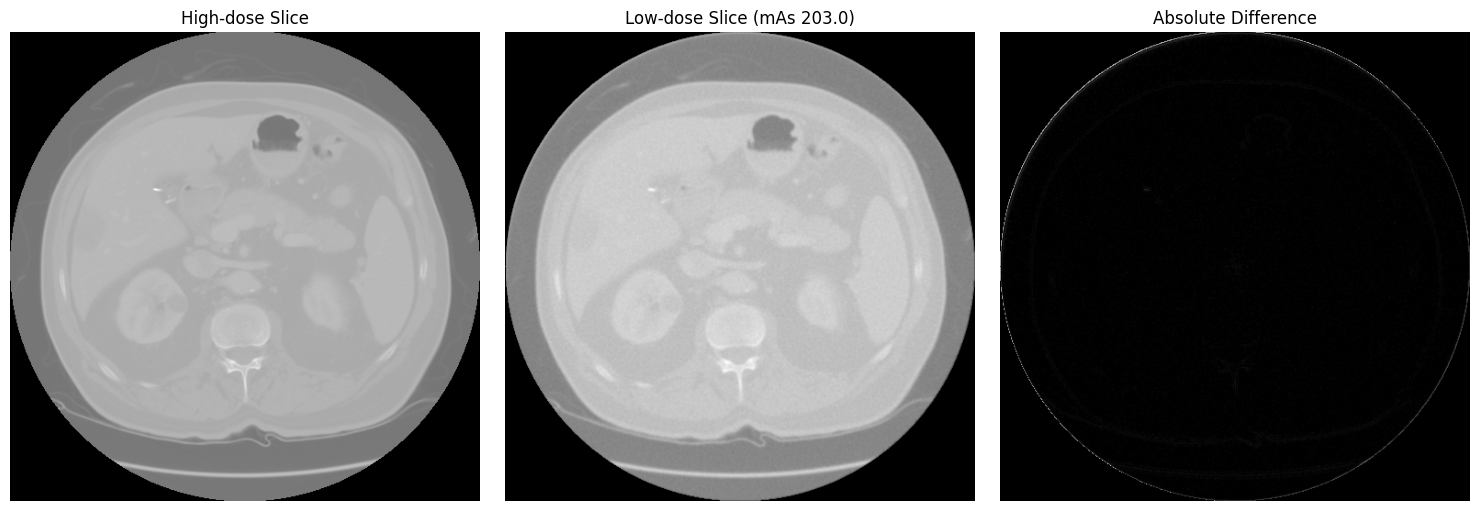

In [11]:
plt.figure(figsize=(15, 5)) 
plt.subplot(1, 3, 1)
plt.imshow(h_slice, cmap='gray')
plt.title("High-dose Slice")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(low_slice, cmap='gray')
plt.title(f"Low-dose Slice (mAs {mas_des})")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(np.abs(h_slice - low_slice), cmap='gray')
plt.title("Absolute Difference")
plt.axis('off')
plt.tight_layout()
plt.show()